In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import residue, residuez, invres, invresz, zpk2tf

In [2]:
def nthroot(a, n):
    return np.power(a, 1/n)

def IIR(fp, fr, Rp, Rr, fs, method):
    if method == "impulse":
        N = int(np.ceil(np.log10(np.sqrt(10**(Rr/10) - 1)/np.sqrt(10**(Rp/10) - 1))/np.log10(fr/fp)))
        fi = (fp + fr)/2
        Ri = (Rp + Rr)/2
        f0 = fi/nthroot(10**(Ri/10) - 1, 2*N)

        k = np.linspace(1, N, N)
        za = []
        pa = 2*np.pi*f0*np.exp(1j*np.pi*(1/2 + (2*k - 1)/(2*N)))
        ka = np.abs(np.prod(pa))

        [ba, aa] = zpk2tf(za, pa, ka)

        [r, p, k] = residue(ba, aa, tol=1e-12)

        r = r/fs
        p = np.exp(p/fs)
        [b, a] = invresz(r, p, k, tol=1e-12)
    elif method == "bilinear":
        fpa = fs/np.pi*np.tan(fp/fs*np.pi)
        fra = fs/np.pi*np.tan(fr/fs*np.pi)

        N = int(np.ceil(np.log10(np.sqrt(10**(Rr/10) - 1)/np.sqrt(10**(Rp/10) - 1))/np.log10(fra/fpa)))
        fi = (fp + fr)/2
        Ri = (Rp + Rr)/2

        fia = fs/np.pi*np.tan(fi/fs*np.pi)
        f0a = fia/nthroot(10**(Ri/10) - 1, 2*N)
        f0 = fs*np.pi*np.arctan(f0a/fs*np.pi)

        k = np.linspace(1, N, N)
        za = np.empty(0)
        pa = 2*np.pi*f0a*np.exp(1j*np.pi*(1/2 + (2*k - 1)/(2*N)))
        ka = np.abs(np.prod(pa))

        [ba, aa] = zpk2tf(za, pa, ka)

        p = (1 + pa/(2*fs))/(1 - pa/(2*fs))
        z = np.empty(0)
        for i in range(len(za)):
            z = np.append(z, (1 + za[i]/(2*fs))/(1 - za[i]/(2*fs)))

        while len(p) > len(z):
            z = np.append(z, -1)

        k = ka*np.prod(2*fs - za)/np.prod(2*fs - pa)

        [b, a] = zpk2tf(z, p, k)
    return b, a

def filtration(b, a, x):
    N = len(x)
    M = len(b)
    K = len(a)
    y = np.zeros(N, dtype=np.complex_)

    for n in range(0, N):
        bm = 0
        ak = 0
        for m in range(0, M):
            if n-m >= 0:
                bm = bm + b[m]*x[n - m]
        for k in range(0, K):
            if n-k >= 0:
                ak = ak + a[k]*y[n - k]
        y[n] = bm - ak

    return y

def ZandP(b, a):
    z = np.roots(b)
    p = np.roots(a)
    return z, p

def transmittanceZ(b, a, N):
    f_ = np.linspace(0, 1/2 - 1/N, N)
    z = np.exp(1j*2*np.pi*f_)

    Y = np.zeros(N)
    X = np.zeros(N)

    M = len(b)
    K = len(a)

    for m in range(M):
        Y = Y + b[m]*np.power(z, -m)

    for k in range(K):
        X = X + a[k]*np.power(z, -k)

    H = Y/X
    return H, f_


[0.00423928 0.01271368 0.00242077] 
 [ 1.         -2.89250952  3.24989583 -1.66376312  0.32574964]
0.0


C:\Users\pkowo\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


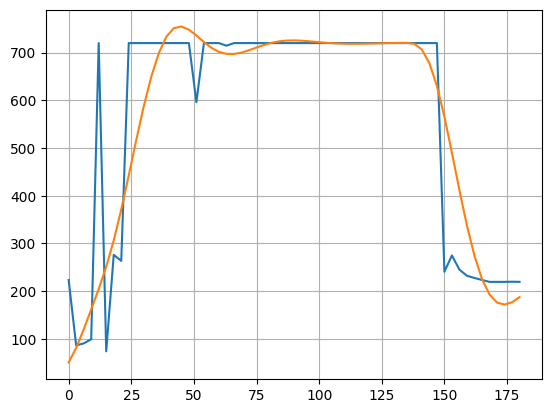

[-2.79469094 -0.20432793]
[0.78267501+0.32773576j 0.78267501-0.32773576j 0.66357975+0.1099895j
 0.66357975-0.1099895j ]


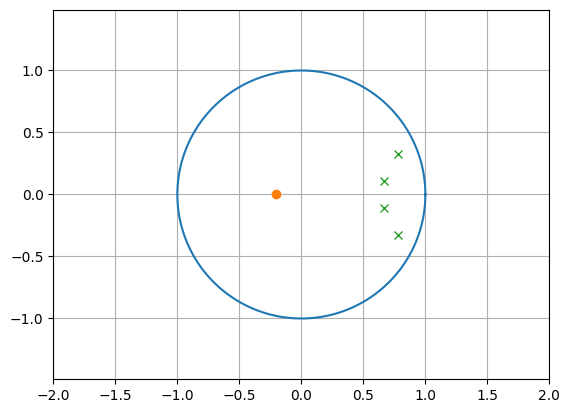

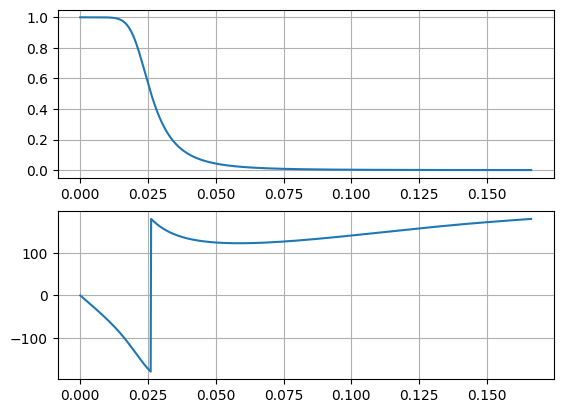

In [3]:
data = pd.read_csv("measures2.csv", sep=',')
angle = data["angle"]
distance = data["value"]

fp = 1/52
fr = 1/24
fs = 1/3

Rp = 1
Rr = 20

[b, a] = IIR(fp, fr, Rp, Rr, fs, "impulse")

distance2 = np.copy(distance)
angle2 = np.copy(angle)
R = len(a)-1
dphi = angle[1] - angle[0]
for i in range(R):
    distance2 = np.append(distance2, distance[len(distance)-1])
    angle2 = np.append(angle2, angle2[len(angle)-1] + dphi * (i + 1))

b = np.real(b)  # wartości urojone są niewielkie, więc można je pominąć
a = np.real(a)
b[0] = 0        # było ~1e-16

b = b[1:]

distance3 = filtration(b, a, distance2)

print(b, "\n", a)
print(np.max(np.abs(np.imag(distance3))))
angle2 = angle2 - dphi * R

plt.plot(angle, distance)
plt.plot(angle2[R :], distance3[R :])
plt.grid()
plt.show()

[z, p] = ZandP(b, a)
print(z)
print(p)

R = 1
phi = np.linspace(0, 2*np.pi + 1/(100*np.pi), 200)
re = R*np.cos(phi)
im = R*np.sin(phi)

plt.plot(re, im)
plt.plot(np.real(z), np.imag(z), 'o')
plt.plot(np.real(p), np.imag(p), 'x')
plt.axis('equal')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.grid()
plt.show()

H, f_ = transmittanceZ(b, a, 1000)
f = f_*fs

plt.subplot(2, 1, 1)
plt.plot(f, np.abs(H))
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(f, np.angle(H)*180/np.pi)
plt.grid()